In [1]:
from imports import *

2024-06-19 18:52:01.916080: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 18:52:01.941802: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 18:52:01.941827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 18:52:01.941846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 18:52:01.946568: I tensorflow/core/platform/cpu_feature_g

In [2]:
data = pd.read_csv('data/15min1h4h/EURUSD15.csv', sep='\t')
data = data[(int(data.shape[0]/2)):]
data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
#original_data = data.copy()

In [3]:
pip_factor = 10000

In [4]:
sys.path.append('src')
from process_data import DataProcessor
from autoformer import Autoformer
from visualize_data import Visualizer
from train_model import ModelTrainer
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()

In [5]:
def apply_butterworth(data, order, cutoff_freq):
    sampling_rate = 1  # one every one minute
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
def create_four_predictions(target_idx, model, input_seq, idx0, idx1, idx2, idx3):
    pred0 = model(input_seq[idx0:idx0+1, :, :], training=False)
    pred1 = model(input_seq[idx1:idx1+1, :, :], training=False)
    pred2 = model(input_seq[idx2:idx2+1, :, :], training=False)
    pred3 = model(input_seq[idx3:idx3+1, :, :], training=False)
    return pred0, pred1, pred2, pred3

In [7]:
input_seq_len = 64
output_seq_len = 16

train_pct = 0.6
val_pct = 0.2

In [8]:
data['bw_open'] = apply_butterworth(data['open'], 5, 1/16)  # 8 minutes
data['bw_high'] = apply_butterworth(data['high'], 5, 1/16)  # 8 minutes
data['bw_low'] = apply_butterworth(data['low'], 5, 1/16)  # 8 minutes
data['bw_close'] = apply_butterworth(data['close'], 5, 1/16)  # 8 minutes

In [9]:
#data['rsi_close_7'] = abstract.RSI(data, timeperiod=7, price='bw_close')
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='bw_close')
#data['willr_close_12'] = abstract.WILLR(data, timeperiod=12, price='bw_close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='bw_close')

In [10]:
data.dropna(how='any', axis=0, inplace=True)

In [11]:
#data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42'])
#data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'willr_close_42', 'bw_close'])

In [12]:
target_time = data[['time', 'rsi_close_14', 'close']]

In [13]:
# data = data_processor.diff_features(data, ['close', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])
# data['close'] *= pip_factor
# data['bw_close'] *= pip_factor
# data['bw_open'] *= pip_factor
# data['bw_high'] *= pip_factor
# data['bw_low'] *= pip_factor

In [14]:
target = data[['close', 'rsi_close_14']]

In [15]:
data.drop(['open', 'high', 'low'], axis=1, inplace=True)

In [16]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [17]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [18]:
Xtrain = (Xtrain_time[:, :, 2:]).astype(np.float64)
Xval = (Xval_time[:, :, 2:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 2:]).astype(np.float64)

ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [19]:
config = {
    'input_seq_len': input_seq_len,
    'O': output_seq_len,
    'pool_size': 64,
    'ac_heads': 4,
    'c': 4,
    'encoder_layers': 1,
    'd_model': 48,
    'd_ff': 48,
    'dropout_rate': 0.1,
    'decoder_layers': 1,
    'd_out': ytrain.shape[-1],
    'd_data': Xtrain.shape[-1],
    'batch_size': 32
}

In [20]:
epochs = 20
path = 'saved_models/af-1906-15m.h5'

model = model_trainer.load_model_autoformer(path, Xtest, config)

#model = Autoformer(config)

2024-06-19 18:52:09.912285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 18:52:09.917494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 18:52:09.917623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [21]:
model, best_epoch, train_losses, val_losses = model_trainer.train_model_autoformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

2024-06-19 09:23:18.338264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2024-06-19 09:23:19.567326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fccdf7b670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-19 09:23:19.567345: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-19 09:23:19.575310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-19 09:23:19.651378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0, Loss: 0.12640627153315961, Val Loss: 0.16663625683828392, Val loss improved
Epoch: 1, Loss: 0.10031000061882159, Val Loss: 0.1461993503773723, Val loss improved
Epoch: 2, Loss: 0.09713090844854967, Val Loss: 0.13558154262332095, Val loss improved
Epoch: 3, Loss: 0.09237872727091845, Val Loss: 0.14559312967750102
Epoch: 4, Loss: 0.0882974269507176, Val Loss: 0.15016505758985849
Epoch: 5, Loss: 0.08366481675815003, Val Loss: 0.1598407854409758
Epoch: 6, Loss: 0.08067780695366221, Val Loss: 0.16356907519723482
Epoch: 7, Loss: 0.07746229887366292, Val Loss: 0.16333856860791643
Epoch: 8, Loss: 0.07523934425691914, Val Loss: 0.16065105969203916
Epoch: 9, Loss: 0.0734312396288244, Val Loss: 0.18056761109240285
Epoch: 10, Loss: 0.07016960810872531, Val Loss: 0.15940898962644418
Epoch: 11, Loss: 0.06863067959462957, Val Loss: 0.1503445290741287
Epoch: 12, Loss: 0.0669223599250679, Val Loss: 0.1866630128145501
Epoch: 13, Loss: 0.06537682230118412, Val Loss: 0.16647111044404478
Epoch: 1

In [ ]:
# (5211, 4765) when target rsi from interval (0;1)
# (5146, 4830) when (-1;1)

In [21]:
pred = model(Xtest, training=False)

In [22]:
close_idx = 1
last_closes_input_seqs = list(Xtest_time[:, -1, close_idx])
close_idx = 0
real_closes_target_seqs = list(ytest_c[:, -1, close_idx])

In [23]:
real_price_movement = [a-b for a, b in zip(last_closes_input_seqs, real_closes_target_seqs)]
real_classes = data_processor.create_binary_classification_classes(real_price_movement, 0.0)

In [24]:
pred_mean = tf.squeeze(pred, axis=-1)
pred_mean = tf.reduce_mean(pred_mean, axis=1)
pred_mean = pred_mean.numpy().tolist()

In [25]:
#real_classes = data_processor.create_binary_classification_classes(ytest_tmp, 0.5)
pred_classes = data_processor.create_binary_classification_classes(pred_mean, 0.5)

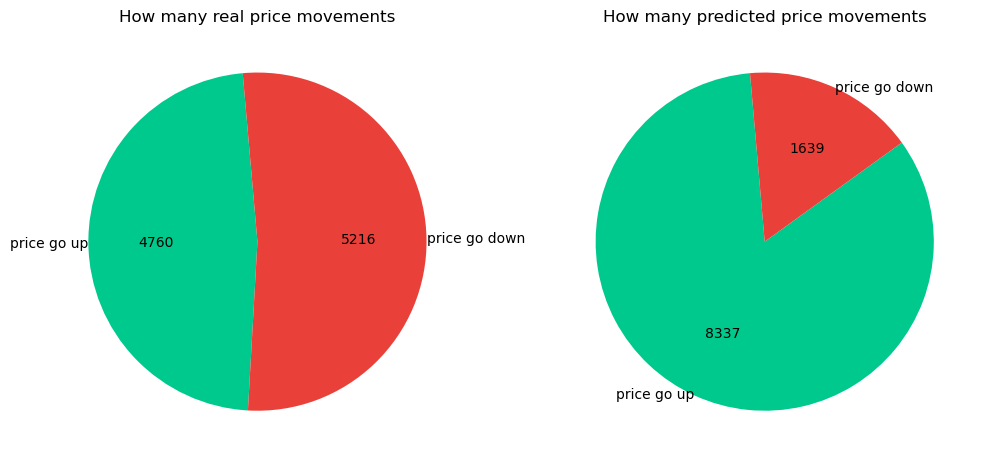

In [26]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)

In [27]:
accuracy_0, precision_0, recall_0, f1_0 = data_processor.create_metrics_from_classes_binary(real_classes, pred_classes)
visualizer.create_metrics_df(accuracy_0, precision_0, recall_0, f1_0)

,Metric,Value
0,Accuracy,0.486468
1,Precision,0.478230
2,Recall,0.837605
3,F1 Score,0.608842


In [28]:
ytest_mean = tf.squeeze(ytest, axis=-1)
ytest_mean = tf.reduce_mean(ytest_mean, axis=1)
ytest_mean = ytest_mean.numpy().tolist()

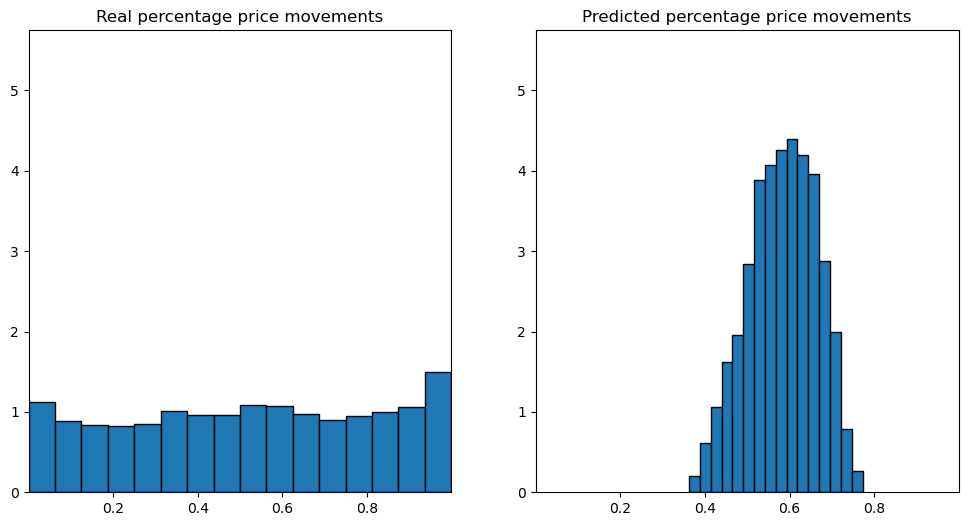

In [29]:
visualizer.plot_two_histograms(ytest_mean, pred_mean)

In [30]:
threshold = 0.05
#real_ternary_classes = data_processor.create_ternary_classification_classes(ytest_mean, threshold, 0.5)
pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_mean, threshold, 0.5)

In [31]:
real_rsis_reduced, pred_rsis_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement, pred_mean)

In [33]:
real_tmp = data_processor.create_binary_classification_classes(real_rsis_reduced, 0.0)
pred_tmp = data_processor.create_binary_classification_classes(pred_rsis_reduced, 0.5)

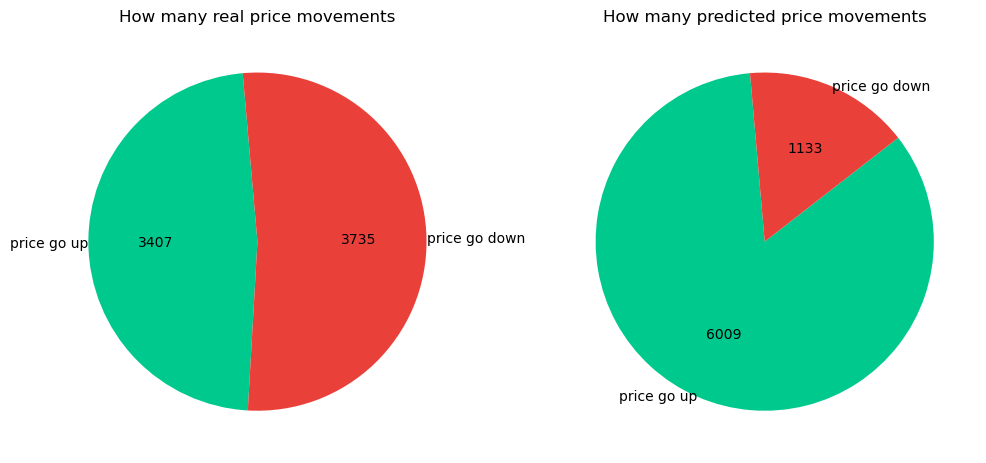

In [34]:
visualizer.pie_number_of_price_movements_binary(real_tmp, pred_tmp)

In [35]:
accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
visualizer.create_metrics_df(accuracy, precision, recall, f1)

,Metric,Value
0,Accuracy,0.481658
1,Precision,0.475453
2,Recall,0.838568
3,F1 Score,0.606839


In [37]:
# accuracies_ternary = []
# precisions_ternary = []
# recalls_ternary = []
# f1s_ternary = []

accuracies_binary = []
precisions_binary = []
recalls_binary = []
f1s_binary = []

start = 0.0
end = 0.5
thresholds = np.linspace(start, end, 50)

for threshold in thresholds:  # threshold == 1 means one percent change in price
    #real_ternary_classes = data_processor.create_ternary_classification_classes(ytest_tmp, threshold, 0.5)
    pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_mean, threshold, 0.5)
    #accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_ternary(real_ternary_classes, pred_ternary_classes)
    #accuracies_ternary.append(accuracy)
    #precisions_ternary.append(precision)
    #recalls_ternary.append(recall)
    #f1s_ternary.append(f1)

    real_rsis_reduced, pred_rsis_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement, pred_mean)
    real_tmp = data_processor.create_binary_classification_classes(real_rsis_reduced, 0.0)
    pred_tmp = data_processor.create_binary_classification_classes(pred_rsis_reduced, 0.5)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
    accuracies_binary.append(accuracy)
    precisions_binary.append(precision)
    recalls_binary.append(recall)
    f1s_binary.append(f1)

/home/radekp/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/radekp/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: 

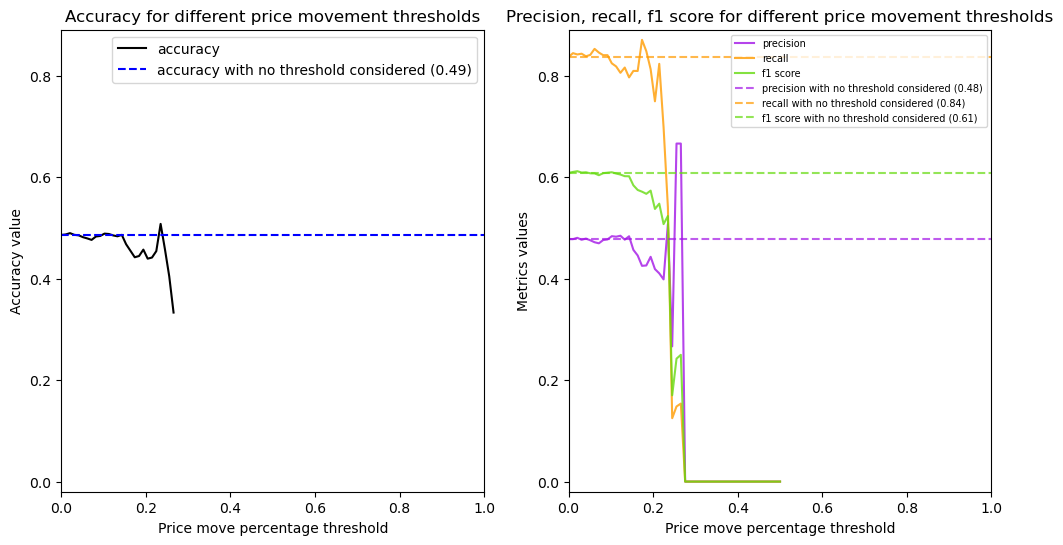

In [38]:
visualizer.plot_metrics_binary(thresholds, accuracies_binary, precisions_binary, recalls_binary, f1s_binary, accuracy_0, precision_0, recall_0, f1_0)